In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics    
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from myFunctions import *

# Getting your data! & Choosing your features

## Echonest

In [2]:
#read echonest.csv
echonest=pd.read_csv("data/echonest.csv")
echonest.shape

(13129, 250)

In [3]:
echonest.tail()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

### A little description of some features:
- track_id: the id of the track
- audio_features_acousticness: a value in [0-1], when the track is closer to 0 it has mainly an electric sound
- audio_features_danceability: a value in [0-1], it's expressing a combination of tempo,rythm, beat strengt, so how suitable is for dancing
- audio_features_energy: a value in [0-1], when the track is closer to 1, the song has fast,loud,noisy sounds
- audio_features_instrumentalness: a value in [0-1], when the track is closer to 1, the song has the high probability that there is no vocals
- audio_features_liveness: a value in [0-1], it describes how likely the song was performed live
- audio_features_speechiness: a value in [0-1], it describes how it is exclusively speech-like the recording
- audio_features_tempo: it describes the number of beats per minute
- audio_features_valence:a value in [0-1], it describes how much the song is positive
- ranks_artist_familiarity_rank: a value in [0-1], it is an indication of how well known the artist is 
- ranks_artist_hotttnesss_rank: a value in [0-1], it gives an indication how much popular the artist is  now
- ranks_song_hotttnesss_rank: a value in [0-1], it gives an indication how much popular the song is now

Now, we are going to drop the columns that are not needed.

In [4]:
# make a copy of our dataframa
e=echonest.copy()
not_dropped_columns=["audio_features_acousticness","audio_features_danceability","audio_features_energy","audio_features_instrumentalness","audio_features_liveness","audio_features_speechiness","audio_features_tempo","audio_features_valence"]
e=e[not_dropped_columns]

 The next step is counting the NA values after the dropping:

In [5]:
e.isnull().sum()

audio_features_acousticness        0
audio_features_danceability        0
audio_features_energy              0
audio_features_instrumentalness    0
audio_features_liveness            0
audio_features_speechiness         0
audio_features_tempo               0
audio_features_valence             0
dtype: int64

We use PCA to make the dataset smaller and to remove the redundancy

this choice was taken for all the datasets.
the reasons are many:
- this removes the correlated features
- it improves the algorithm performance
- it gives the possibility to choose the quantity of information to keep

However it has some disavantages:
- indenpendent variables become hard to find
- there is a limited information loss

First step is Standardization, to make that each variable  contributes equally to the analysis.
$$
  z=\frac {value - mean } {standardDeviation}\
$$

In [6]:
normalised_columns=["audio_features_acousticness","audio_features_danceability","audio_features_energy","audio_features_instrumentalness","audio_features_liveness","audio_features_speechiness","audio_features_tempo","audio_features_valence"]
for col in normalised_columns:
    mean=e[col].mean()
    std=e[col].std()
    e[col]=(e[col]- mean)/std
e.tail()

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence
13124,-1.347590,1.593882,0.653745,0.588157,3.371778,-0.121012,0.521259,1.632803
13125,-1.259230,1.871104,-0.003667,0.621462,2.278674,-0.183240,-0.602741,0.134351
13126,-1.367052,0.643687,1.286177,0.570201,2.816183,-0.346898,0.197513,0.206162
13127,-0.513687,0.458252,0.038883,-0.519239,-0.707848,-0.478858,0.540593,0.469204
13128,1.222038,0.063364,-1.751107,0.844259,-0.581069,-0.247380,-0.088963,-0.851755


In [7]:
e.shape

(13129, 8)

I compute the PCA on this dataset, creating principals to get a total variance that is more than 70 %.

In [8]:
pca = PCA(n_components = 0.70)
X_new = pca.fit_transform(e)
x=pca.transform(e)
x.shape

(13129, 5)

Here we create a new dataframe and insert again the track_id

In [9]:
e=pd.DataFrame(x)
e= e.add_suffix("_e")
e["track_id"]=echonest["track_id"]
e.tail()

,0_e,1_e,2_e,3_e,4_e,track_id
13124,2.191704,-0.318925,1.393943,-0.202148,3.170866,124857
13125,1.030108,0.204303,0.380319,-1.237604,2.154335,124862
13126,1.313609,-1.285334,1.433216,-0.927871,2.191933,124863
13127,0.874314,-0.093119,-0.605274,0.155213,-0.460692,124864
13128,-2.014566,0.716116,-0.897026,0.713075,-0.183085,124911


## Features.csv

In [10]:
#read features.csv
features=pd.read_csv("data/features.csv")
features.shape

(106574, 519)

In [11]:
features.tail()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma

<div>
<img src = "geatures.png" width = "1000px">
</div>

Here we count the NA values

In [12]:
any(features.isnull().sum())

False

There aren't NA value in this dataset. So now we do again the standardization.

In [13]:
for col in features:
    if col!="track_id":
        mean=features[col].mean()
        std=features[col].std()
        features[col]=(features[col]- mean)/std
features.tail()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma

In [14]:
f=features.loc[:, features.columns != 'track_id']

We proceed with the PCA on this dataset

In [15]:
pca = PCA(n_components = 0.70)
X_new = pca.fit_transform(f)
x=pca.transform(f)
x.shape

(106574, 49)

In [16]:
f=pd.DataFrame(x)
f= f.add_suffix("_f")
f["track_id"]=features["track_id"]
f.tail()

,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f,18_f,19_f,20_f,21_f,22_f,23_f,24_f,25_f,26_f,27_f,28_f,29_f,30_f,31_f,32_f,33_f,34_f,35_f,36_f,37_f,38_f,39_f,40_f,41_f,42_f,43_f,44_f,45_f,46_f,47_f,48_f,track_id
106569,4.521090,3.592282,4.814302,0.176416,-2.663378,-5.605925,5.976875,-4.734692,-2.195631,4.877248,1.010812,0.638822,1.832573,-3.469070,-0.317018,-1.112135,0.032730,-0.147167,0.080515,2.260466,2.248000,0.425854,0.170850,0.700185,-0.972345,0.121915,1.732652,-2.907601,-3.451752,-0.774050,1.753469,-0.155382,-0.096253,-0.102236,1.223008,0.364491,1.020125,0.405858,0.056333,0.522882,0.299160,-0.928834,-0.116797,-0.086796,-1.085349,-0.598789,-1.167047,0.515455,0.215776,155316
106570,2.857380,-1.721077,6.610401,-0.152467,-3.033324,-1.872516,-2.067716,-4.343499,6.093661,0.804432,-0.546733,2.086688,2.863895,0.143406,1.720299,-0.012627,-0.116037,0.589395,1.286175,0.062854,3.953875,-0.240036,0.370991,0.182966,1.118372,1.268662,1.530532,-3.658650,-0.151598,-0.176527,0.245127,0.909048,1.042501,1.146318,-2.296564,2.315711,-0.428679,0.497090,-1.076291,-1.306162,-0.196141,0.495725,-0.276749,1.365028,0.458413,0.512996,-0.077323,-0.033656,0.468724,155317
106571,5.174977,-1.204837,1.603648,-0.319232,-3.534399,-4.021149,2.267544,-2.181984,-0.645739,2.570556,0.131661,3.073024,2.055843,-2.931284,0.047331,-0.313393,0.146934,-0.046264,1.508742,0.800836,1.758275,-0.106083,-1.329053,2.628540,0.568330,-1.249158,2.904697,-2.190580,-0.656976,-1.161422,0.281811,-0.349507,-0.271574,0.680345,1.463276,0.474955,0.157987,0.453933,-0.217481,-0.985478,0.465548,0.583010,-0.938821,0.289973,0.091346,0.479983,0.468083,0.416247,-0.512364,155318
106572,8.265630,0.375061,2.059360,0.260039,-3.860936,-1.888375,1.617334,-0.833865,-1.297191,-1.003489,-0.818661,1.622709,0.714079,-0.964037,2.296622,0.734420,0.827082,-0.502915,2.623595,0.267729,0.216533,-0.850769,-1.704863,2.304090,1.218488,-1.584730,1.204775,-0.579959,-2.722810,0.093190,-0.173745,0.785030,0.175795,0.794482,1.703499,1.618872,-0.209987,0.648859,1.633353,-1.468662,-0.383515,0.444749,-1.069334,-0.240083,0.442809,-0.288046,-0.410383,-0.358338,-0.171715,155319
106573,6.421836,-3.717963,1.547332,-0.387468,-2.421620,2.693624,1.767465,-3.243041,0.638989,1.583866,-0.395433,1.442757,-2.433112,-1.109864,-1.496075,0.483631,0.280841,1.840381,-1.650330,-0.701626,-0.306559,2.754749,-0.086499,2.316974,-2.408225,0.046487,-1.770120,0.020629,0.279623,0.589278,2.002681,-0.043094,-0.235105,0.584378,0.461841,-1.021359,0.235668,0.668289,0.660465,0.579846,-1.163483,-0.152286,1.119229,-1.321676,0.727328,-1.303294,-0.997994,-0.412088,0.694625,155320


## Tracks.csv

In [17]:
tracks=pd.read_csv("data/tracks.csv")
tracks.shape

(106574, 53)

In [18]:
tracks.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [19]:
#Let's check which are the top genre
print(*{x for x in set(tracks["track_genre_top"]) if isinstance(x , str) or not math.isnan(x)}, sep = "\n")

Jazz
Pop
Rock
Blues
Old-Time / Historic
Instrumental
International
Folk
Country
Experimental
Soul-RnB
Spoken
Electronic
Hip-Hop
Classical
Easy Listening


### Now a list of all the attributes and their NA values:

In [20]:
tracks.isnull().sum()

track_id                         0
album_comments                   0
album_date_created            3529
album_date_released          36280
album_engineer               91279
album_favorites                  0
album_id                         0
album_information            23425
album_listens                    0
album_producer               88514
album_tags                       0
album_title                   1025
album_tracks                     0
album_type                    6508
artist_active_year_begin     83863
artist_active_year_end      101199
artist_associated_labels     92303
artist_bio                   35418
artist_comments                  0
artist_date_created            856
artist_favorites                 0
artist_id                        0
artist_latitude              62030
artist_location              36364
artist_longitude             62030
artist_members               59725
artist_name                      0
artist_related_projects      93422
artist_tags         

I selected the columns according to columns that can be used with pca and columns that have few NA values.

In [21]:
t=tracks.copy()
not_dropped_columns=["track_bit_rate","track_duration" ]
t=t[not_dropped_columns]
t.head()

,track_bit_rate,track_duration
0,256000,168
1,256000,237
2,256000,206
3,192000,161
4,256000,311


In [22]:
t.isnull().sum()

track_bit_rate    0
track_duration    0
dtype: int64

We use PCA to make the dataset smaller and to remove the redundancy

First step is Standardization, to make that each variable  contributes equally to the analysis.
$$
  z=\frac {value - mean } {standardDeviation}\
$$

In [23]:
cols= ["track_bit_rate","track_duration"]
for col in cols:
    mean=t[col].mean()
    std=t[col].std()
    t[col]=(t[col]- mean)/std
t.tail()

,track_bit_rate,track_duration
106569,0.838841,-0.379188
106570,0.838841,-0.199167
106571,0.838841,0.412907
106572,0.838841,-0.431558
106573,0.838841,-0.261356


In [24]:
pca = PCA(n_components = 0.70)
X_new = pca.fit_transform(t)
x=pca.transform(t)

In [25]:
t=pd.DataFrame(x)
t= t.add_suffix("_t")
t["track_id"]=tracks["track_id"]
t["track_genres"]=tracks["track_genres"]
t["track_genres_all"]=tracks["track_genres_all"]
t["track_genre_top"]=tracks["track_genre_top"]
t.tail()

,0_t,1_t,track_id,track_genres,track_genres_all,track_genre_top
106569,-0.861277,0.325023,155316,[25],"[25, 12]",Rock
106570,-0.733982,0.452318,155317,[25],"[25, 12]",Rock
106571,-0.301180,0.885120,155318,[25],"[25, 12]",Rock
106572,-0.898308,0.287992,155319,[25],"[25, 12]",Rock
106573,-0.777957,0.408343,155320,"[10, 12, 169]","[169, 10, 12, 9]",NaN


### Here we merge all the datasets using the track_id

In [26]:
new_df = e.merge(f, on = ["track_id"])
new_df=new_df.merge(t,on=["track_id"])
new_df.tail()

,0_e,1_e,2_e,3_e,4_e,track_id,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f,18_f,19_f,20_f,21_f,22_f,23_f,24_f,25_f,26_f,27_f,28_f,29_f,30_f,31_f,32_f,33_f,34_f,35_f,36_f,37_f,38_f,39_f,40_f,41_f,42_f,43_f,44_f,45_f,46_f,47_f,48_f,0_t,1_t,track_genres,track_genres_all,track_genre_top
13124,2.191704,-0.318925,1.393943,-0.202148,3.170866,124857,5.654954,-5.399555,-0.732309,-0.470455,-3.339372,0.197122,-1.856222,0.773075,-0.583382,0.578757,2.893493,-1.662092,-0.762253,3.242431,0.497539,-1.157991,0.500650,-0.168191,-0.573674,-0.957207,-0.614425,-0.435154,0.955003,-1.274151,-0.146893,-1.484636,1.399197,0.946527,-0.966661,-0.742128,0.108541,-0.045313,0.024702,0.767078,0.239183,-0.956990,0.113041,-0.000853,-0.214624,-0.790502,0.419939,1.731740,-0.571841,-1.283941,0.932976,-0.032154,0.295780,0.041719,0.941858,-0.615945,0.570355,"[286, 542]","[542, 21, 286, 15]",NaN
13125,1.030108,0.204303,0.380319,-1.237604,2.154335,124862,14.575185,-3.654180,-1.060828,-1.135116,5.274854,-5.029580,-1.286160,1.537077,2.169493,2.804998,0.056193,1.558619,-1.640853,-1.258083,-1.189545,-0.711861,-2.040140,-4.626648,-0.258014,-1.490640,0.495319,-0.703624,0.484673,0.708102,0.552364,0.852527,-0.176936,-1.852061,-1.229876,2.540551,-2.568680,1.824908,0.478333,1.168093,0.957972,-0.618811,0.182941,-0.604846,-0.322889,0.885444,2.238607,1.099757,1.064644,-0.027331,1.684506,-0.715552,-1.843854,-0.915598,-0.520525,-0.671492,0.514808,"[286, 542]","[542, 21, 286, 15]",NaN
13126,1.313609,-1.285334,1.433216,-0.927871,2.191933,124863,16.214974,-4.070105,-2.227093,0.181622,3.107514,-0.340338,-4.569157,-0.960578,-1.139680,2.022710,0.765565,2.235224,1.140811,-1.433643,-0.122810,-0.109519,-1.647489,-2.007784,-1.224596,-1.970608,-0.731053,-0.409807,-1.550359,1.415542,0.644946,-1.652567,1.244342,-2.912009,-1.230619,0.515407,-2.358912,1.408040,-0.284379,1.637155,0.807694,0.518530,-0.675094,0.719383,-0.769243,-1.160211,1.534106,1.400934,-0.332165,0.507357,1.922125,0.085338,-0.668226,-0.616866,-1.727230,-0.352098,0.834202,"[286, 542]","[542, 21, 286, 15]",NaN
13127,0.874314,-0.093119,-0.605274,0.155213,-0.460692,124864,-2.644719,-2.042644,-2.478622,-0.733204,-2.443440,3.682911,2.359418,1.404421,-4.002921,-1.158370,0.761587,0.346159,2.723527,2.650389,1.846995,-1.485119,-1.841582,-1.755682,-0.386403,-0.146953,0.200445,0.838968,0.267898,-1.174650,-0.714509,-1.650884,0.974620,-1.032778,1.362578,1.559981,0.084551,-0.403393,-1.382532,-0.366068,0.443529,0.660351,-0.034355,-1.054233,0.520170,-0.159058,-0.501961,-0.499195,1.367240,-0.799616,0.855896,-0.084176,0.184418,0.481671,0.906451,-0.565027,0.621273,"[286, 542]","[542, 21, 286, 15]",NaN
13128,-2.014566,0.716116,-0.897026,0.713075,-0.183085,124911,-12.393515,7.834558,6.801349,-0.132948,0.063433,-1.805182,-0.669520,1.120778,0.598564,0.478942,-0.963262,-3.430400,-2.426567,0.759145,-5.384284,2.064558,3.079738,-0.568389,2.312450,-1.184435,-1.782568,-1.953385,3.040360,-1.177946,0.402610,-0.159801,-1.946551,1.329099,-1.934814,-2.539025,-1.325503,2.798207,1.489756,1.528062,-1.608552,0.912500,-1.026715,1.161539,0.471525,-0.869708,-3.458786,1.748824,-0.367324,-0.897372,0.418566,-0.219898,-0.557172,-0.978981,0.153221,-0.435418,0.750882,"[5, 15]","[5, 15]",NaN


In [27]:
#save our result in a csv file
new_df.to_csv("final_dataset.csv",index=False)

# Clustering

Now we are going to apply k_means to this dataset

Our k_means choose randomly k points as the first centroids and then associate each point in the cluster to the cluster whose centroid is the nearest.
After these steps it computes again new centroids using the mean and it redoes all the distances again.
this is done until for 2 successive steps we have a difference equal to 0 between the new centroids and the old ones.

In [28]:
def K_scratch(dataframe,k,iters):
    #it moves the keys at the end of the rows
    ids=dataframe["track_id"].copy()
    del dataframe["track_id"]
    dataframe["track_id"]=ids
    dataframe["cluster_#"]=0

    differences=[]
    
    #it takes k rows from the dataframe excluding the string columns
    centroids=dataframe.iloc[:,:-5].sample(n=k)
    first=False
    diff=1
    steps=1
    PastDistance=0
    dataframe["cluster_#"]=0
    while diff!=0 and steps<=iters:
        distanceSum=0
        steps+=1
        #it iterates on each row(point)
        for i in range(len(dataframe)):
            #it keeps the distance of each node to the k clusters
            support=np.zeros(k)
            #it iterates on each centroids
            for j in range(len(centroids)):
                #it fills with all the distances
                r=np.asarray(dataframe.iloc[i,:-5])
                c=np.asarray(centroids.iloc[j,:])
                dist = np.linalg.norm(r-c)
                support[j]=dist
            #it associates the  i point to the cluster that minimize the distance that corrisponds to the index of support
            index=np.argmin(support)
            #it measure the total distance from each point to the centroid that is the nearest
            distanceSum+=support[index]
            dataframe.loc[i,"cluster_#"]=index
            #new centroids
        differences.append(distanceSum)   
        new_centroids=dataframe.groupby(["cluster_#"],group_keys=False).mean().iloc[:,:-1]
        if first:
            v=new_centroids-centroids
            diff=np.sum(np.sum(v,axis=1))
            PastDistance=distanceSum
            centroids=new_centroids.copy()
        else:
            diff=1
            PastDistance=distanceSum
            centroids=new_centroids.copy()
            first=True
    vect=np.asarray(differences)
    return vect

In [71]:
def elbow_method(dataframe):
    distanceMeasures=[]
    for k in range(2,20):
        vec=K_scratch(dataframe,k,10)
        distance=vec[-1]
        distanceMeasures.append(distance)
    plt.plot(distanceMeasures,"b-o")
    plt.grid(visible=True)
    plt.xticks(range(0,18), range(2,20))
    plt.show()

In [72]:
dataset=pd.read_csv("final_dataset.csv")

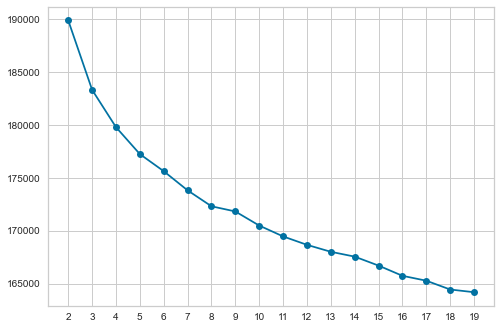

In [73]:
elbow_method(dataset)

Using the elbow method seems that 11 is the right number to choose 

Now we use the other chosen method: silhoutte method

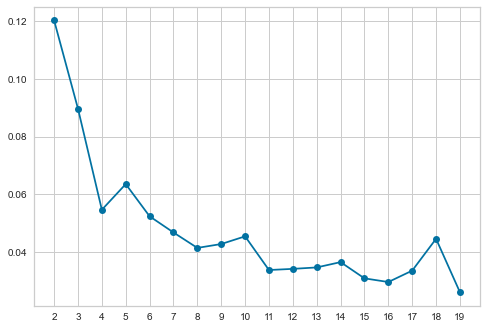

In [75]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 19

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    K_scratch(dataset,k,10)
    labels = np.asarray(dataset["cluster_#"])
    sil.append(silhouette_score(X=dataset.iloc[:,:-5],labels=labels, metric='euclidean'))
plt.plot(sil,"b-o")
plt.grid(visible=True)
plt.xticks(range(0,18), range(2,20))
plt.show()

Both using the elbow method and the silhoutte method we learn that the best number of  cluster is 11!

## K-means++ implementation

In [31]:
datasetplus=pd.read_csv("final_dataset.csv")

In [32]:
# we use the kmeans function from sklearn and output the labels
%%time
kmeans = KMeans(n_clusters=11, random_state=0,init="k-means++",max_iter=10).fit(datasetplus.iloc[:,:-5])

Wall time: 215 ms


In [33]:
kmeans.labels_

array([5, 5, 5, ..., 1, 1, 1])

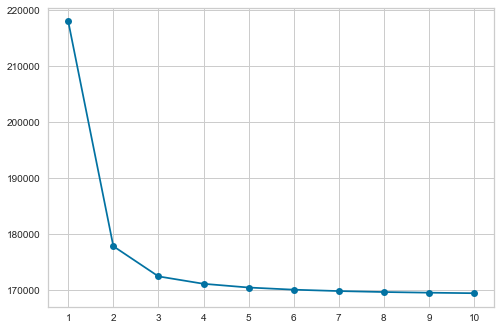

Wall time: 6min 32s


In [70]:
# run also our function
%%time
vect=K_scratch(dataset,11,10)
plt.plot(vect,"b-o")
plt.xticks(range(0,10),range(1,11))
plt.show()

In [35]:
dataset["cluster_#"].to_numpy()

array([8, 8, 8, ..., 9, 8, 2], dtype=int64)

In [36]:
# to check between the two clustering methods we will use the adjusted_rand_score from sklearn
adjusted_rand_score(kmeans.labels_,dataset["cluster_#"].to_numpy())

0.010657057797898226

Well, turns out that our algorithm takes roughly 400 seconds to run, while the sklearn one runs in just below a quarter of a second. this makes the sklearn one roughly 2k times faster. Also the adjusted_rand_score is very close to 0 so the two predictions are very far from one another.

In [37]:
dataset.to_csv("cluster_dataset.csv",index=False)

# Analysing my results!

At first we run once more our own k-means algo with 11 clusters to obtain the results, then we create an inverted dictionary to assign to each cluster the corresponding songs that belong to it.

The plot is describing the inertia in comparison at the number of iterations

In [38]:
# below the inverted index dictionary
diz ={}
df=dataset[["track_id","cluster_#"]]
for index in range (13128) :
    row=df.iloc[index,:]
    track_id=row[0]
    cluster_id=row[1]
    if cluster_id not in diz:
        diz[cluster_id]=[track_id]
    else:
        diz[cluster_id].append(track_id)

with open('data/dictionary_myKmean.pkl','wb') as f:
        pickle.dump(diz,f)

From here on out we begin the analysis. We decided to use 6 variables
+ audio_features_tempo
+ audio_features_danceability
+ audio_features_liveness
+ audio_features_speechiness
+ audio_features_instrumentalness
+ track_duration 

#### Bitrate (audio_features_tempo)
The first table shows that the majority of songs across all clusters is between 80 and 130 bitrates, with values ranging from 45% in clusters #2 and #10 to the 60% encountered in cluster #11. Interesting is also the case of cluster #3 where 1 out of five songs has a bitrate below 80.

In [39]:
with open('data/dictionary_myKmean.pkl','rb') as f:
            diz = pickle.load(f)

printPivotTableBit(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,bit < 80,7.29%,4.72%,19.85%,13.43%,8.45%,3.38%,12.86%,16.65%,7.60%,5.51%,4.96%
1,80 < bit < 130,54.90%,46.53%,52.88%,56.67%,56.83%,47.27%,55.84%,56.50%,53.92%,45.95%,58.84%
2,130 < bit < 180,31.53%,41.75%,22.54%,26.46%,31.13%,42.31%,27.53%,21.44%,29.46%,36.59%,28.34%
3,bit > 180,6.28%,7.00%,4.74%,3.43%,3.59%,7.04%,3.77%,5.41%,9.02%,11.95%,7.86%
4,TOT,100.00%,100.00%,100.01%,99.99%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


#### Danceability
The second table here shows how some clusters are clearly more danceable than others. Clusters #1, #9 and #11 have above 65% of the songs with more that 0.50 danceability, where the top position is kept by #11 at over 80% cumulative. On the other hand clusters such as #2, #3, and #7 have very low values of danceability overall, in cluster #3 infact almost 75% of the songs have a danceability score below 0.50.

In [40]:
printPivotTableDanceability(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,25%,1.51%,20.74%,16.13%,11.21%,10.85%,16.17%,13.12%,12.49%,1.99%,23.28%,2.15%
1,< 50%,21.48%,53.31%,59.92%,51.72%,41.69%,46.87%,49.35%,40.89%,22.81%,44.80%,15.43%
2,< 75%,53.89%,24.05%,23.18%,34.75%,41.34%,34.59%,35.06%,39.65%,53.46%,25.78%,49.11%
3,75%>,23.12%,1.90%,0.77%,2.32%,6.13%,2.37%,2.47%,6.97%,21.74%,6.13%,33.30%
4,TOT,100.00%,100.00%,100.00%,100.00%,100.01%,100.00%,100.00%,100.00%,100.00%,99.99%,99.99%


#### Liveness
The variable may express the relative probability of the song to be live, and there doesn't seem to be much information here, all the cluster have very low liveness, in clusters #4 and #5 for example almost 9 out of 10 songs in the cluster has a minuscule liveness score.

In [41]:
printPivotTableLiveness(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,25%,85.18%,76.66%,60.31%,86.06%,86.06%,75.94%,84.68%,83.14%,77.70%,68.71%,82.97%
1,< 50%,11.43%,16.83%,25.10%,8.48%,10.99%,17.35%,10.78%,11.03%,16.06%,20.89%,14.13%
2,< 75%,3.14%,5.05%,8.58%,4.04%,2.04%,4.85%,3.64%,5.10%,4.99%,8.21%,2.25%
3,75%>,0.25%,1.47%,6.02%,1.41%,0.92%,1.86%,0.91%,0.73%,1.25%,2.18%,0.65%
4,TOT,100.00%,100.01%,100.01%,99.99%,100.01%,100.00%,100.01%,100.00%,100.00%,99.99%,100.00%


#### Speechiness
Here again the variable might express the presence of a determined set of frequencies that make up the human voice. As before all values are flattened in the first category, with a speechiness score below 0.25 that in some clusters grows as high as 98%! particular mention to cluster #11 which has overall higher values for this parameter.

In [42]:
printPivotTableSpeechiness(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,25%,86.56%,96.47%,91.93%,98.48%,97.75%,96.68%,98.44%,93.86%,71.06%,92.72%,80.54%
1,< 50%,10.68%,2.28%,4.48%,1.21%,1.76%,3.15%,1.30%,4.37%,16.97%,5.30%,15.72%
2,< 75%,2.39%,0.87%,1.41%,0.20%,0.49%,0.17%,0.26%,0.83%,6.30%,1.46%,2.62%
3,75%>,0.38%,0.38%,2.18%,0.10%,0.00%,0.00%,0.00%,0.94%,5.68%,0.52%,1.12%
4,TOT,100.01%,100.00%,100.00%,99.99%,100.00%,100.00%,100.00%,100.00%,100.01%,100.00%,100.00%


#### Instrumentalness
The instrumentalness score on the other hand revolves around the quantity of instrumentals in the song, we get the highest values in cluster #3 and the lowest in clusters #8 and #9. peculiar is the case of cluster #9 where songs seem to be either incredibly instrumental or not at all.

In [43]:
printPivotTableInstrumentalness(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,25%,20.60%,14.22%,13.83%,21.41%,21.41%,26.14%,19.87%,33.30%,45.23%,13.41%,14.03%
1,< 50%,5.90%,5.75%,2.56%,5.76%,5.00%,7.04%,6.36%,6.56%,6.75%,5.41%,4.40%
2,< 75%,9.67%,9.72%,3.46%,9.49%,10.77%,14.65%,9.09%,12.28%,10.90%,12.89%,9.07%
3,75%>,63.82%,70.30%,80.15%,63.33%,62.82%,52.17%,64.68%,47.87%,37.12%,68.30%,72.50%
4,TOT,99.99%,99.99%,100.00%,99.99%,100.00%,100.00%,100.00%,100.01%,100.00%,100.01%,100.00%


#### Duration
We divided the categories in songs shorter than 2 minutes, between 2 and 8, 8 and 12, and longer than 12. Of course the majority of the songs is in the second category but we can still derive some insight. For example cluster #10 has the highest number of short songs, while cluster #8 contains the longest ones.

In [44]:
printPivotTableDuration(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,0-120s,9.42%,17.81%,12.29%,11.31%,8.10%,9.97%,7.27%,9.26%,10.33%,29.52%,10.38%
1,120-480s,87.31%,78.83%,83.35%,83.84%,86.34%,87.94%,87.40%,75.44%,83.54%,69.44%,84.66%
2,480-720s,3.14%,2.33%,2.05%,3.43%,3.17%,1.58%,3.64%,6.35%,3.23%,0.83%,3.74%
3,720>,0.13%,1.03%,2.30%,1.41%,2.39%,0.51%,1.69%,8.95%,2.89%,0.21%,1.22%
4,TOT,100.00%,100.00%,99.99%,99.99%,100.00%,100.00%,100.00%,100.00%,99.99%,100.00%,100.00%


#### Genres
*sidenote: since many songs had NaN values on the genre_top variable the following percentages were calculated according to the songs which had a non-null value as the maximum*
After all the different variables seen in the last slides we come here to see the truth behind these clusters. Cluster #3 with low bitrate, danceability and speech is mostly made up of historical and classical music, that checks out. Clusters #1 and #9 are very similar, both have high values for rock, hip hop and electronic music. Clusters #4 and #7 are unique as a combination of folk-rock. Clusters #2 and #6 are also similar as both have very high values of rock music. Cluster #11 is filled with electronic and hip-hop, meaning that songs that mix the two genres are grouped here here.

In [45]:
printPivotTableGenres(diz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11
0,Hip-Hop,27.59%,4.19%,0.16%,1.72%,4.20%,5.00%,1.34%,2.21%,31.98%,7.10%,18.71%
1,Pop,3.89%,2.55%,0.32%,5.60%,4.73%,3.41%,4.58%,9.17%,4.77%,2.14%,1.08%
2,Rock,18.15%,76.05%,1.77%,31.99%,55.15%,73.35%,37.98%,13.92%,13.17%,59.17%,9.83%
3,Experimental,0.00%,0.07%,0.32%,0.14%,0.00%,0.40%,0.38%,0.34%,0.09%,0.27%,0.13%
4,Folk,1.85%,4.58%,11.94%,36.30%,12.50%,2.14%,32.25%,18.00%,2.25%,2.28%,0.40%
5,Jazz,1.11%,1.51%,2.42%,4.73%,3.78%,1.82%,3.63%,9.68%,1.73%,0.80%,0.40%
6,Electronic,45.74%,7.20%,3.06%,10.19%,15.23%,13.24%,9.16%,28.86%,41.25%,27.04%,69.31%
7,International,0.00%,1.18%,0.65%,2.58%,0.63%,0.24%,5.34%,3.23%,2.60%,0.94%,0.00%
8,Blues,0.37%,0.85%,0.65%,1.58%,1.26%,0.16%,1.15%,1.70%,0.52%,0.00%,0.00%
9,Classical,0.00%,0.65%,23.06%,3.01%,0.42%,0.08%,3.05%,10.19%,0.87%,0.00%,0.00%


# K-means++ again

Now we performed again the k-means++ analysis without using the variables from the file echonest.csv, so we take in account only datas from features.csv and tracks.csv. Let's create our dataset:

In [46]:
#load file features
features=pd.read_csv("data/features.csv")

#normalize all the values
for col in features:
    if col!="track_id":
        mean=features[col].mean()
        std=features[col].std()
        features[col]=(features[col]- mean)/std

f=features.loc[:, features.columns != 'track_id']

#execute the PCA on features
pca = PCA(n_components = 0.70)
X_new = pca.fit_transform(f)
x=pca.transform(f)

f=pd.DataFrame(x)
f= f.add_suffix("_features")
f["track_id"]=features["track_id"]
f.head()

,0_features,1_features,2_features,3_features,4_features,5_features,6_features,7_features,8_features,9_features,10_features,11_features,12_features,13_features,14_features,15_features,16_features,17_features,18_features,19_features,20_features,21_features,22_features,23_features,24_features,25_features,26_features,27_features,28_features,29_features,30_features,31_features,32_features,33_features,34_features,35_features,36_features,37_features,38_features,39_features,40_features,41_features,42_features,43_features,44_features,45_features,46_features,47_features,48_features,track_id
0,2.060060,-3.089425,-5.565897,0.080540,2.309259,-3.597815,-5.054186,-0.889460,-5.108289,-4.067422,3.572921,-1.159984,-2.207837,-1.590577,0.223468,0.433005,-1.436552,1.154619,-0.077386,1.605491,-1.225725,-0.316249,0.250171,-2.847016,0.360653,-3.041283,0.892071,1.449692,-0.321161,0.564564,1.440013,-0.743917,-0.548343,-0.478786,-0.800450,0.595387,1.367687,-0.865030,-0.115468,0.701889,-2.255720,0.352273,-1.812983,-0.385805,-1.353170,-0.144009,-0.795258,1.588611,0.892261,2
1,3.509229,-5.384901,-4.332552,-1.113455,-3.068285,2.204026,-0.234568,4.726556,-0.604038,-3.417886,2.969556,0.127853,-0.722156,0.904160,-1.056872,-2.531495,-0.230248,0.510510,-2.259653,0.534650,-0.161707,-1.717520,1.427575,-3.051037,0.573442,-2.698406,-0.714678,1.074096,-0.859664,2.312495,-0.855569,0.707543,0.354506,-1.060267,1.844360,-1.362437,2.580927,-1.632463,1.159813,0.914112,-1.623615,1.195633,-0.955472,0.405990,-0.122112,0.697009,-0.585094,2.636835,-0.177605,3
2,0.954588,-3.178007,-3.494701,-0.934796,-1.098683,0.455748,-2.390555,1.266910,0.984996,-1.733512,2.806501,-2.365269,-0.655929,0.470486,0.112722,-0.440212,-1.329592,0.536810,0.613813,2.531010,0.213037,-0.983671,-0.159937,-2.368901,-3.419323,-1.974337,2.764425,1.807653,-1.772850,-0.106142,2.107326,0.077253,-0.829433,-0.471845,2.604778,0.328108,0.566731,-1.895724,1.725595,1.045798,-0.848433,0.523567,-0.615558,0.542988,-1.050340,0.036632,-1.478031,1.834802,-0.275640,5
3,6.695399,1.329777,-5.129129,-0.915308,-2.155906,-0.120454,0.072621,3.904935,0.213867,-2.841634,1.364947,1.260867,0.323505,2.791088,2.677133,-1.369205,-0.696569,0.325818,-0.943319,1.015012,-2.506278,-2.761315,0.190590,0.912295,-1.293202,0.417753,-0.336509,-2.035355,3.588996,-1.083363,2.753521,1.246869,0.050735,1.078595,2.261790,0.200076,1.084177,0.234083,2.954890,0.206753,-0.037722,-0.153327,0.113327,0.843542,-0.054427,-0.498014,-0.674813,-1.253856,-0.908244,10
4,0.870796,-1.123608,2.985161,-0.830487,-2.443368,4.542666,-0.159430,-1.837109,1.026201,-2.033911,-0.940291,-2.119107,1.312819,5.708004,-0.101214,0.445859,1.724458,-0.290226,0.503630,-1.364630,1.843650,1.081817,1.090732,0.447306,1.157095,1.097125,-1.372940,1.356526,1.129796,0.238176,-1.081955,-1.342897,0.115790,-1.200916,0.533753,-1.740970,0.746124,-2.422139,-1.195527,1.322813,0.255862,2.031229,-0.617358,-1.745584,-0.134673,-0.460641,-0.503799,-0.530338,-0.390838,20


In [47]:
#load file tracks
tracks=pd.read_csv("data/tracks.csv")
t=tracks.copy()
cols=["track_bit_rate","track_duration","track_listens", 
      "track_interest", "track_favorites", "track_duration",
      "track_bit_rate", "album_tracks",                     
      "album_listens", "artist_favorites"]
t=t[cols]

#normalize all the values
for col in cols:
    mean=t[col].mean()
    std=t[col].std()
    t[col]=(t[col]- mean)/std
t.head()

#execute the PCA on tracks
Y_new = pca.fit_transform(t)
y=pca.transform(t)

t=pd.DataFrame(x)
t= t.add_suffix("_t")
t["track_id"]=tracks["track_id"]
t["track_genres"]=tracks["track_genres"]
t["track_genres_all"]=tracks["track_genres_all"]
t["track_genre_top"]=tracks["track_genre_top"]

In [48]:
#create the final dataset merging the twos just created
final_df = f.merge(t, on = ["track_id"])
final_df.head()

,0_features,1_features,2_features,3_features,4_features,5_features,6_features,7_features,8_features,9_features,10_features,11_features,12_features,13_features,14_features,15_features,16_features,17_features,18_features,19_features,20_features,21_features,22_features,23_features,24_features,25_features,26_features,27_features,28_features,29_features,30_features,31_features,32_features,33_features,34_features,35_features,36_features,37_features,38_features,39_features,40_features,41_features,42_features,43_features,44_features,45_features,46_features,47_features,48_features,track_id,0_t,1_t,2_t,3_t,4_t,5_t,6_t,7_t,8_t,9_t,10_t,11_t,12_t,13_t,14_t,15_t,16_t,17_t,18_t,19_t,20_t,21_t,22_t,23_t,24_t,25_t,26_t,27_t,28_t,29_t,30_t,31_t,32_t,33_t,34_t,35_t,36_t,37_t,38_t,39_t,40_t,41_t,42_t,43_t,44_t,45_t,46_t,47_t,48_t,track_genres,track_genres_all,track_genre_top
0,2.060060,-3.089425,-5.565897,0.080540,2.309259,-3.597815,-5.054186,-0.889460,-5.108289,-4.067422,3.572921,-1.159984,-2.207837,-1.590577,0.223468,0.433005,-1.436552,1.154619,-0.077386,1.605491,-1.225725,-0.316249,0.250171,-2.847016,0.360653,-3.041283,0.892071,1.449692,-0.321161,0.564564,1.440013,-0.743917,-0.548343,-0.478786,-0.800450,0.595387,1.367687,-0.865030,-0.115468,0.701889,-2.255720,0.352273,-1.812983,-0.385805,-1.353170,-0.144009,-0.795258,1.588611,0.892261,2,2.060060,-3.089425,-5.565897,0.080540,2.309259,-3.597815,-5.054186,-0.889460,-5.108289,-4.067422,3.572921,-1.159984,-2.207837,-1.590577,0.223468,0.433005,-1.436552,1.154619,-0.077386,1.605491,-1.225725,-0.316249,0.250171,-2.847016,0.360653,-3.041283,0.892071,1.449692,-0.321161,0.564564,1.440013,-0.743917,-0.548343,-0.478786,-0.800450,0.595387,1.367687,-0.865030,-0.115468,0.701889,-2.255720,0.352273,-1.812983,-0.385805,-1.353170,-0.144009,-0.795258,1.588611,0.892261,[21],[21],Hip-Hop
1,3.509229,-5.384901,-4.332552,-1.113455,-3.068285,2.204026,-0.234568,4.726556,-0.604038,-3.417886,2.969556,0.127853,-0.722156,0.904160,-1.056872,-2.531495,-0.230248,0.510510,-2.259653,0.534650,-0.161707,-1.717520,1.427575,-3.051037,0.573442,-2.698406,-0.714678,1.074096,-0.859664,2.312495,-0.855569,0.707543,0.354506,-1.060267,1.844360,-1.362437,2.580927,-1.632463,1.159813,0.914112,-1.623615,1.195633,-0.955472,0.405990,-0.122112,0.697009,-0.585094,2.636835,-0.177605,3,3.509229,-5.384901,-4.332552,-1.113455,-3.068285,2.204026,-0.234568,4.726556,-0.604038,-3.417886,2.969556,0.127853,-0.722156,0.904160,-1.056872,-2.531495,-0.230248,0.510510,-2.259653,0.534650,-0.161707,-1.717520,1.427575,-3.051037,0.573442,-2.698406,-0.714678,1.074096,-0.859664,2.312495,-0.855569,0.707543,0.354506,-1.060267,1.844360,-1.362437,2.580927,-1.632463,1.159813,0.914112,-1.623615,1.195633,-0.955472,0.405990,-0.122112,0.697009,-0.585094,2.636835,-0.177605,[21],[21],Hip-Hop
2,0.954588,-3.178007,-3.494701,-0.934796,-1.098683,0.455748,-2.390555,1.266910,0.984996,-1.733512,2.806501,-2.365269,-0.655929,0.470486,0.112722,-0.440212,-1.329592,0.536810,0.613813,2.531010,0.213037,-0.983671,-0.159937,-2.368901,-3.419323,-1.974337,2.764425,1.807653,-1.772850,-0.106142,2.107326,0.077253,-0.829433,-0.471845,2.604778,0.328108,0.566731,-1.895724,1.725595,1.045798,-0.848433,0.523567,-0.615558,0.542988,-1.050340,0.036632,-1.478031,1.834802,-0.275640,5,0.954588,-3.178007,-3.494701,-0.934796,-1.098683,0.455748,-2.390555,1.266910,0.984996,-1.733512,2.806501,-2.365269,-0.655929,0.470486,0.112722,-0.440212,-1.329592,0.536810,0.613813,2.531010,0.213037,-0.983671,-0.159937,-2.368901,-3.419323,-1.974337,2.764425,1.807653,-1.772850,-0.106142,2.107326,0.077253,-0.829433,-0.471845,2.604778,0.328108,0.566731,-1.895724,1.725595,1.045798,-0.848433,0.523567,-0.615558,0.542988,-1.050340,0.036632,-1.478031,1.834802,-0.275640,[21],[21],Hip-Hop
3,6.695399,1.329777,-5.129129,-0.915308,-2.155906,-0.120454,0.072621,3.904935,0.213867,-2.841634,1.364947,1.260867,0.323505,2.791088,2.677133,-1.369205,-0.696569,0.325818,-0.943319,1.015012,-2.506278,-2.761315,0.190590,0.912295,-1.293202,0.417753,-0.336509,

In [49]:
final_df.to_csv("final_dataset_k++.csv",index=False)
#finally we get a datset with ~100k rows
final_df.shape

(106574, 102)

Now that we got our dataset, we perform the k-means++ algorithm and to decidece the optimal value of number of clusters we use the elbow method and the silhouette score:

In [50]:
silhouette_scores = {}
distortions = {}

for k in range(2,20):
    model_kmeans_k = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    model_kmeans_k.fit(final_df.iloc[:,:-5])
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(final_df.iloc[:,:-5], labels_k)
    silhouette_scores[k] = score_k
    distortions[k] = model_kmeans_k.inertia_
    
    print("k = %d\tSS: %5.4f\t distortion: %5.4f\t" % (k, score_k, model_kmeans_k.inertia_))
    
print("Done!")

k = 2	SS: 0.6379	 distortion: 51047796097130.6328	
k = 3	SS: 0.6036	 distortion: 22530928449158.9453	
k = 4	SS: 0.5664	 distortion: 13348838839475.9805	
k = 5	SS: 0.5580	 distortion: 8449166771164.2139	
k = 6	SS: 0.5672	 distortion: 5635761594668.4648	
k = 7	SS: 0.5464	 distortion: 4348892382869.4302	
k = 8	SS: 0.5484	 distortion: 3269462747323.4663	
k = 9	SS: 0.5414	 distortion: 2618835440819.2334	
k = 10	SS: 0.5390	 distortion: 2132364408279.8220	
k = 11	SS: 0.5474	 distortion: 1728970162953.6072	
k = 12	SS: 0.5499	 distortion: 1423670634125.6833	
k = 13	SS: 0.5523	 distortion: 1221445271394.6511	
k = 14	SS: 0.5478	 distortion: 1035765914795.2771	
k = 15	SS: 0.5528	 distortion: 899023696875.5028	
k = 16	SS: 0.5482	 distortion: 794138160129.0548	
k = 17	SS: 0.5496	 distortion: 701476333391.1144	
k = 18	SS: 0.5483	 distortion: 630510397796.3110	
k = 19	SS: 0.5484	 distortion: 567256947972.8627	
Done!


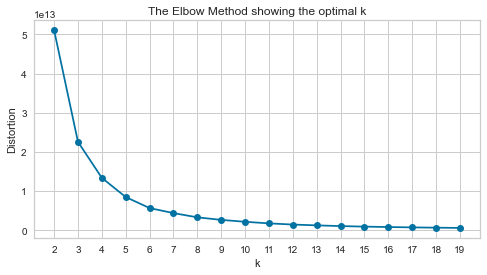

In [69]:
plt.figure(figsize=(8,4))
plt.plot(distortions.values(), 'bo-')
plt.xticks(range(0,18), distortions.keys())
plt.grid(visible=True)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

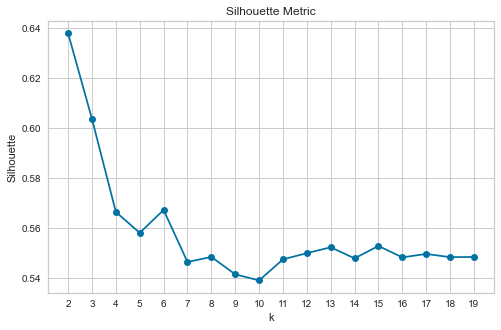

In [51]:
plt.figure(figsize = (8,5))
plt.plot(silhouette_scores.values(), 'bo-')
plt.xticks(range(0,18), silhouette_scores.keys())
plt.title("Silhouette Metric")
plt.grid(visible=True)
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

From graph analysis we can say that the optimal value of number of clusters is: 10

In [59]:
kmeans_model = KMeans(n_clusters = 10)
kmeans_model.fit(final_df.iloc[:,:-5])

final_df["cluster_#"] = kmeans_model.labels_

In [60]:
dizz ={}
df=final_df[["track_id","cluster_#"]]
for index in range (len(final_df)) :
    row=df.iloc[index,:]
    track_id=row[0]
    cluster_id=row[1]
    if cluster_id not in dizz:
        dizz[cluster_id]=[track_id]
    else:
        dizz[cluster_id].append(track_id)
        
with open('data/dictionary_k++.pkl','wb') as f:
        pickle.dump(dizz,f)

Now that we got our dictionary that contains for each number of cluster the correspondent track_id, we can analyze the results obtained in order to see if we can recognize the different genres.

We decided to analyze the next 5 features:
- Duration: how much time a song lasts;
- RMSEE mean: it express the mean effective power of the signal sound;
- RMSEE max: it express the max effective power of the signal sound;
- Spectral Bandwidth mean: the difference between the upper and lower frequencies;
- Zero Crossing rate mean: is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive.

#### Duration

In [2]:
with open('data/dictionary_k++.pkl','rb') as f:
            dizz = pickle.load(f)

printPivotTableDuration(dizz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10
0,0-120s,20.50%,14.05%,16.18%,17.18%,12.61%,12.20%,17.67%,16.18%,19.89%,18.45%
1,120-480s,71.25%,76.01%,72.87%,74.03%,78.05%,76.61%,73.34%,76.18%,72.48%,73.18%
2,480-720s,3.89%,6.18%,5.68%,4.97%,5.84%,6.23%,4.81%,4.55%,4.44%,3.78%
3,720>,4.36%,3.76%,5.27%,3.82%,3.50%,4.96%,4.18%,3.10%,3.19%,4.58%
4,TOT,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.01%,100.00%,99.99%


#### RMSEE mean

In [3]:
printPivotTableRMSEEmean(dizz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10
0,RMSEE < 1.25,7.78%,8.43%,7.87%,5.79%,5.50%,6.89%,6.16%,5.24%,7.55%,8.33%
1,1.25 < RMSEE < 2.5,22.95%,18.30%,20.47%,15.87%,13.99%,18.69%,17.83%,15.97%,17.28%,20.59%
2,2.5 < RMSEE < 3.75,24.23%,21.33%,20.89%,21.95%,18.93%,21.48%,21.77%,23.23%,19.98%,23.81%
3,RMSEE > 3.75,45.03%,51.95%,50.77%,56.38%,61.58%,52.94%,54.24%,55.56%,55.19%,47.27%
4,TOT,99.99%,100.01%,100.00%,99.99%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


#### RMSEE max

In [4]:
printPivotTableRMSEEmax(dizz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10
0,RMSEE < 5,4.92%,5.29%,6.30%,3.41%,3.16%,3.94%,4.01%,3.02%,4.75%,5.09%
1,5 < RMSEE < 10,29.43%,23.12%,25.84%,21.49%,20.14%,24.68%,24.94%,23.39%,22.36%,28.08%
2,10 < RMSEE < 20,59.62%,65.71%,60.85%,67.25%,68.70%,64.13%,61.48%,66.46%,66.67%,59.75%
3,RMSEE > 20,6.02%,5.88%,7.01%,7.85%,8.00%,7.25%,9.57%,7.13%,6.22%,7.08%
4,TOT,99.99%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


#### Spectral Bandwidth

In [5]:
printPivotTableSpectral(dizz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10
0,bandwidth < 500,0.96%,2.30%,1.63%,1.62%,2.04%,1.60%,1.38%,1.43%,1.97%,2.17%
1,500 < bandwidth < 1000,14.75%,19.46%,18.37%,16.49%,15.14%,18.97%,16.54%,15.01%,19.10%,16.36%
2,1000 < bandwidth < 1800,67.84%,60.32%,62.67%,63.32%,62.77%,61.13%,61.21%,65.51%,61.43%,62.12%
3,bandwidth > 1800,16.45%,17.91%,17.32%,18.57%,20.06%,18.30%,20.87%,18.06%,17.50%,19.35%
4,TOT,100.00%,99.99%,99.99%,100.00%,100.01%,100.00%,100.00%,100.01%,100.00%,100.00%


#### Zero crossing rate

In [3]:
printPivotTableZero(dizz)

,Variables,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10
0,zcr < 0.02,4.32%,8.41%,6.04%,7.33%,6.78%,9.20%,5.70%,5.51%,7.04%,4.61%
1,0.02 < zcr < 0.04,27.60%,32.91%,30.89%,31.80%,30.13%,32.60%,29.36%,31.46%,35.27%,27.10%
2,0.04 < zcr < 0.06,33.99%,30.58%,33.12%,30.71%,32.98%,30.45%,31.70%,32.44%,31.58%,33.49%
3,zcr > 0.06,34.10%,28.09%,29.94%,30.16%,30.11%,27.75%,33.24%,30.59%,26.11%,34.80%
4,TOT,100.01%,99.99%,99.99%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


Analyizing all the pivot table we notice that the distribution of the values are too homogenous and we can't tell which cluster corrispond to which genre.